# Configure

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
from os.path import join

os.environ["USE_PYGEOS"] = "0"
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Filepath directories

# Get the absolute path to the project directory
# Which is one directory above notebooks/
ABS_DIR = os.path.abspath(Path(os.getcwd()).parents[1])
# Get raw data directory
FR = join(ABS_DIR, 'data', 'raw')
# Get interim data directory
FI = join(ABS_DIR, 'data', 'interim')
# Get processed data directory
FP = join(ABS_DIR, 'data', 'results')

# Reference fips
FIPS = '42101'

# Load ensemble and default estimates

In [8]:
ens_df = pd.read_parquet(join(FP, 'ensemble.pqt'))
def_df = pd.read_parquet(join(FP, 'default.pqt'))

In [ ]:
# Also load in damage functions

# Visualize the ensemble

## Compare aggregate EAL

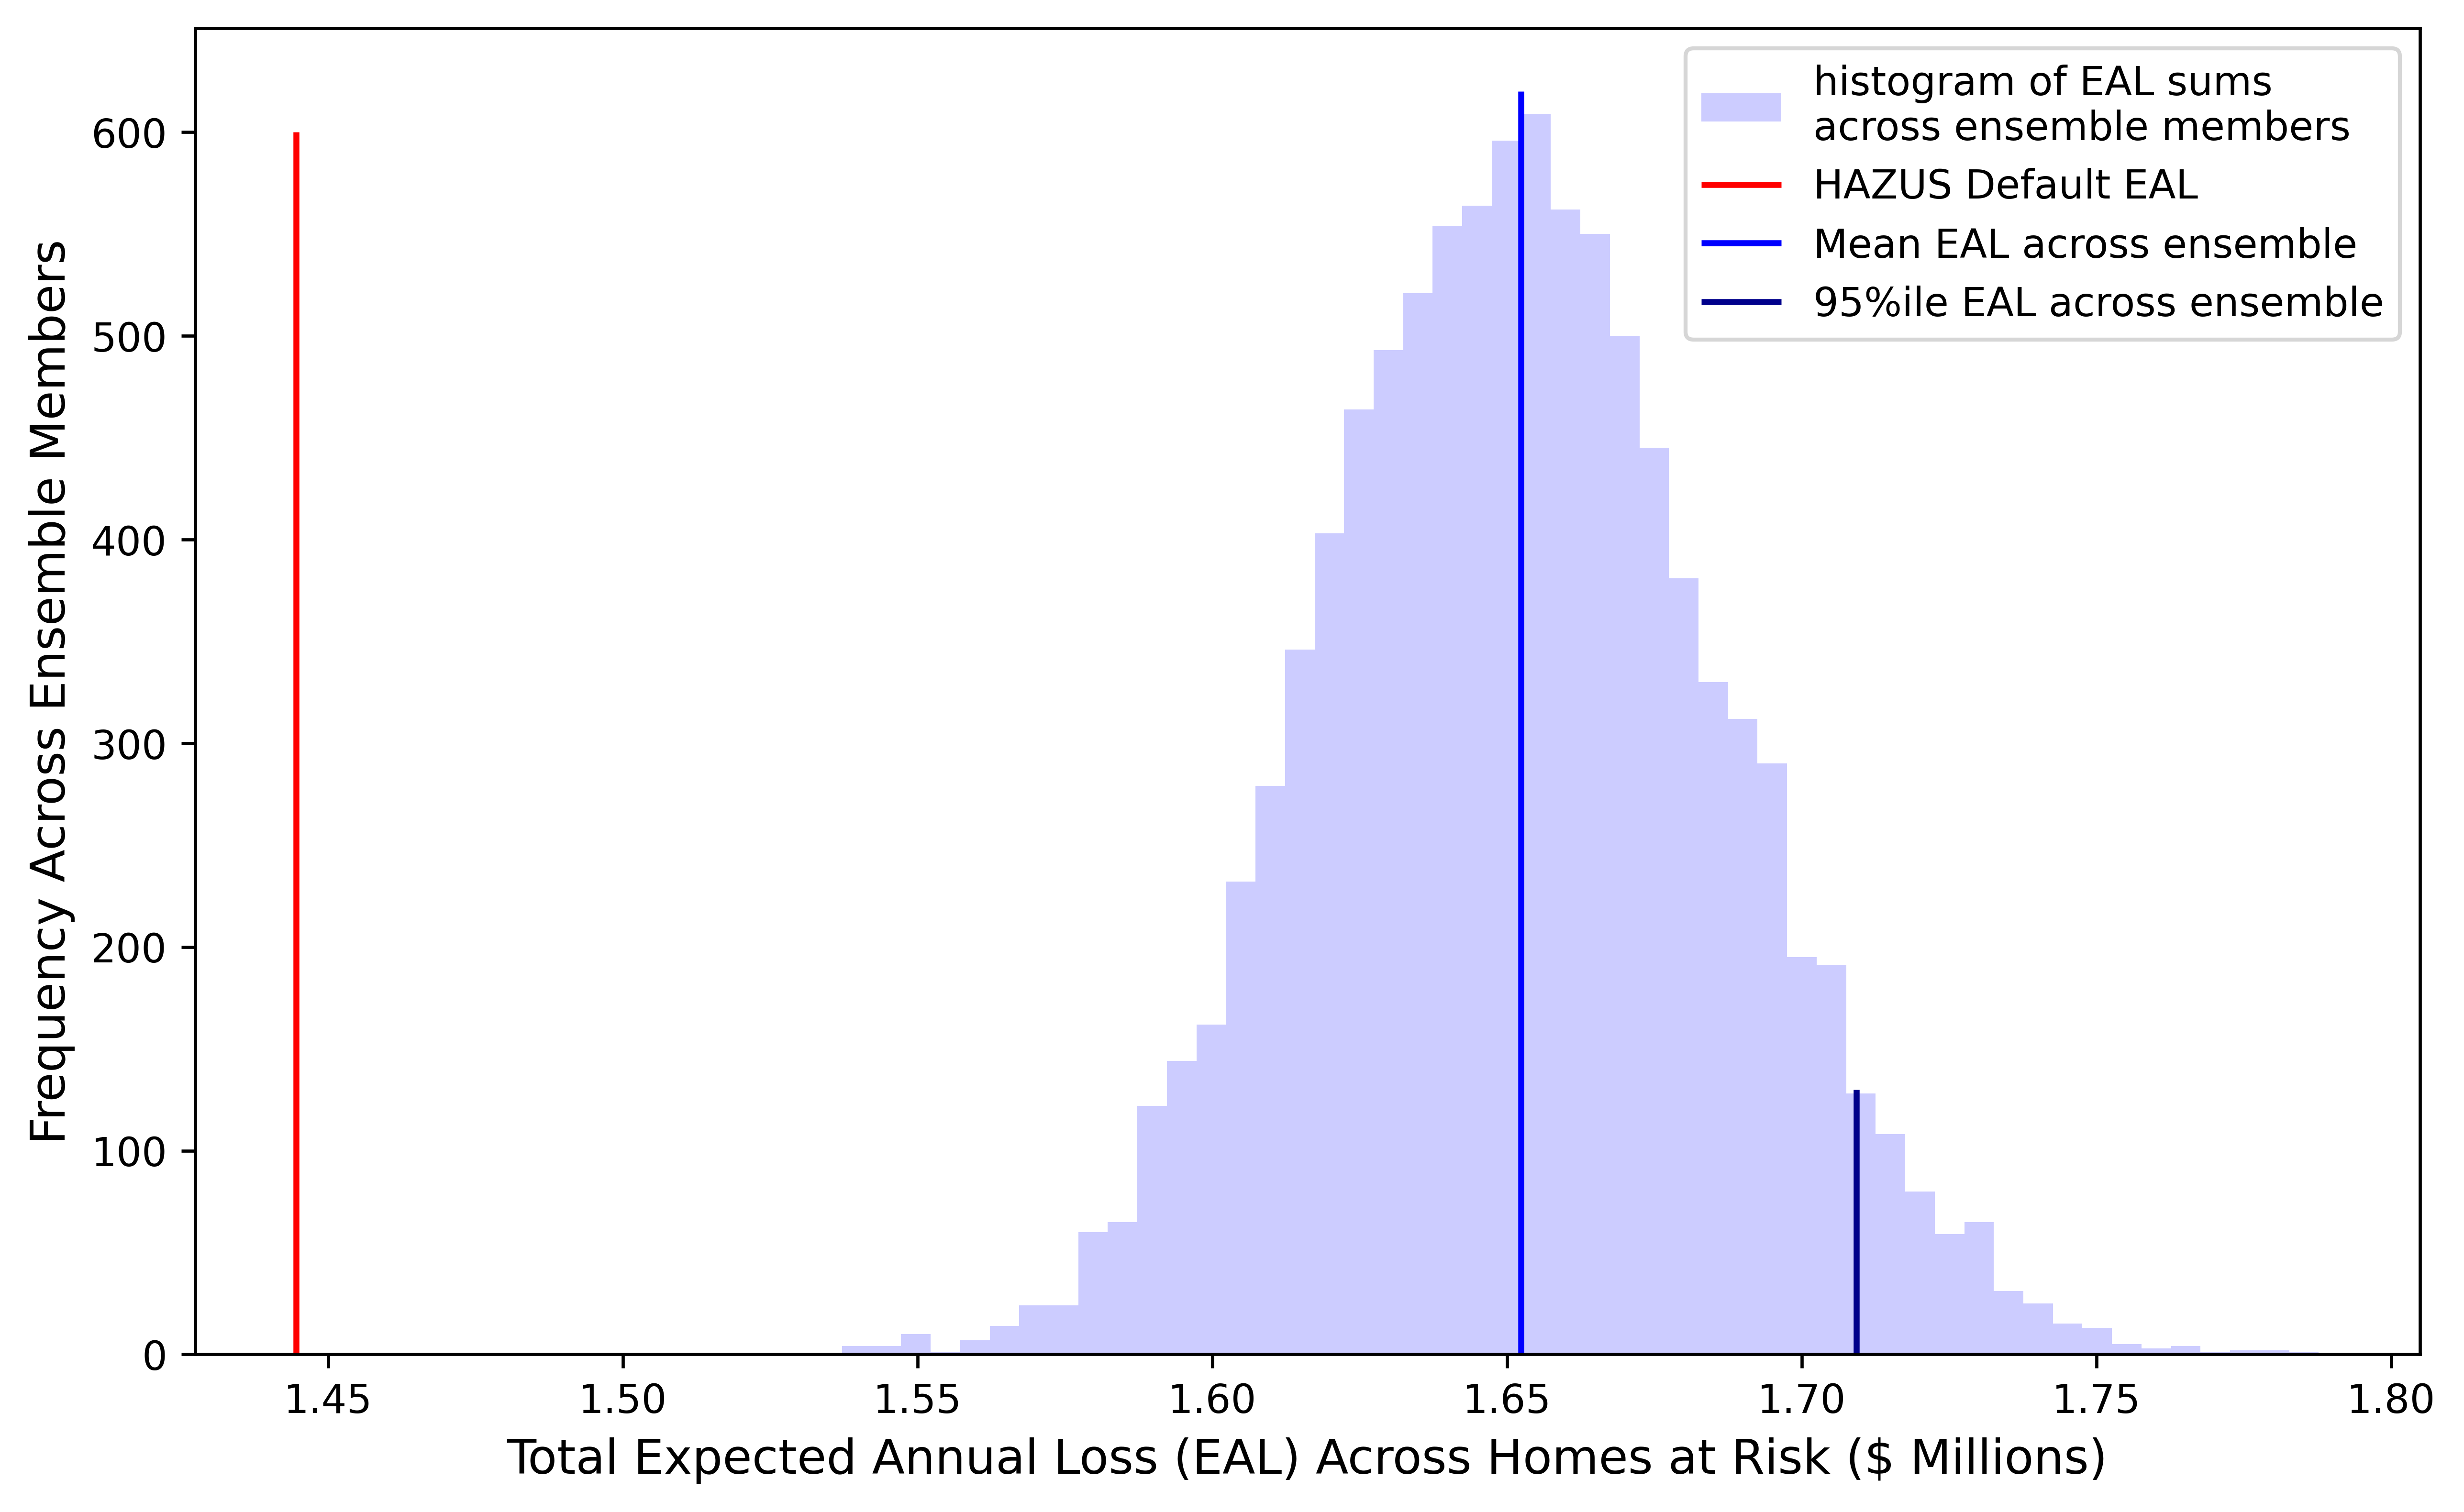

In [14]:
# Plot of the pdf of summed EAL within each SOW against the
# single value from default method
ens_sums = ens_df.groupby(['sow_ind'])['eal'].sum()/1e6
fig, ax = plt.subplots(figsize=(10, 6),
                       dpi=600)
ens_sums.plot(kind='hist', ax=ax, color='blue', bins=50, alpha=.2,
              label='histogram of EAL sums\nacross ensemble members')
ax.vlines(def_df['eal'].sum()/1e6, 0, 600, color='red', label='HAZUS Default EAL')
ax.vlines(ens_sums.mean(), 0, 620, color='blue', label='Mean EAL across ensemble')
ax.vlines(ens_sums.quantile(.95), 0, 130, color='darkblue', label='95%ile EAL across ensemble')
ax.set_xlabel('Total Expected Annual Loss (EAL) Across Homes at Risk ($ Millions)', size=12)
ax.set_ylabel('Frequency Across Ensemble Members', size=12)
ax.legend(loc='upper right')


# Save fig
fig.savefig('/jumbo/keller-lab/projects/icom/nsi_unc/Figures/benchmark.png',
            bbox_inches='tight',
            dpi=600)

## Compare property level EAL

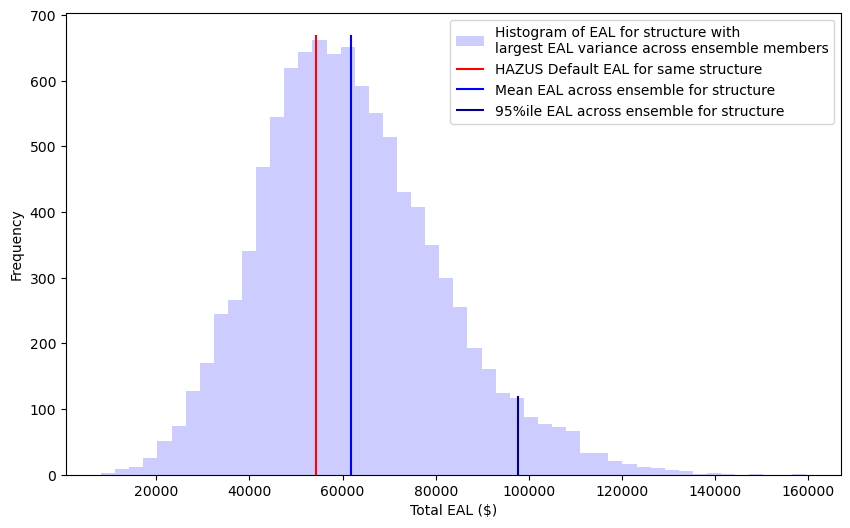

In [30]:
# Look at the proeprty with the largest variance in EAL across SOWs
# Plot the distribution of EAL for this property and plot
# what the benchmark point estimate is
max_var_id = ens_df.groupby(['fd_id'])['eal'].std().idxmax()
max_var_ens = ens_df[ens_df['fd_id'] == max_var_id]
max_var_def = def_df[def_df['fd_id'] == max_var_id]
fig, ax = plt.subplots(figsize=(10, 6))
max_var_ens['eal'].plot(kind='hist', ax=ax, color='blue', bins=50, alpha=.2,
                        label='Histogram of EAL for structure with\nlargest EAL variance across ensemble members')
ax.vlines(max_var_def['eal'], 0, 670, color='red', alpha=1, label='HAZUS Default EAL for same structure')
ax.vlines(max_var_ens['eal'].mean(), 0, 670, color='blue', label='Mean EAL across ensemble for structure')
ax.vlines(max_var_ens['eal'].quantile(.95), 0, 120, color='darkblue', label='95%ile EAL across ensemble for structure')
ax.set_xlabel('Total EAL ($)')
ax.legend(loc='upper right')

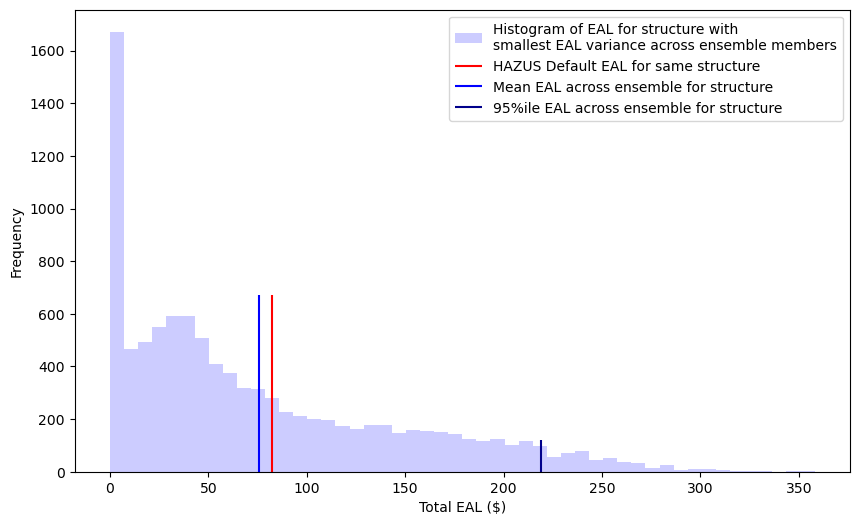

In [47]:
# Look at the proeprty with the smallest variance in EAL across SOWs
# Plot the distribution of EAL for this property and plot
# what the benchmark point estimate is
min_var_id = ens_df.groupby(['fd_id'])['eal'].std().idxmin()
min_var_ens = ens_df[ens_df['fd_id'] == min_var_id]
min_var_def = def_df[def_df['fd_id'] == min_var_id]
fig, ax = plt.subplots(figsize=(10, 6))
min_var_ens['eal'].plot(kind='hist', ax=ax, color='blue', bins=50, alpha=.2,
                        label='Histogram of EAL for structure with\nsmallest EAL variance across ensemble members')
ax.vlines(min_var_def['eal'], 0, 670, color='red', alpha=1, label='HAZUS Default EAL for same structure')
ax.vlines(min_var_ens['eal'].mean(), 0, 670, color='blue', label='Mean EAL across ensemble for structure')
ax.vlines(min_var_ens['eal'].quantile(.95), 0, 120, color='darkblue', label='95%ile EAL across ensemble for structure')
ax.set_xlabel('Total EAL ($)')
ax.legend(loc='upper right')

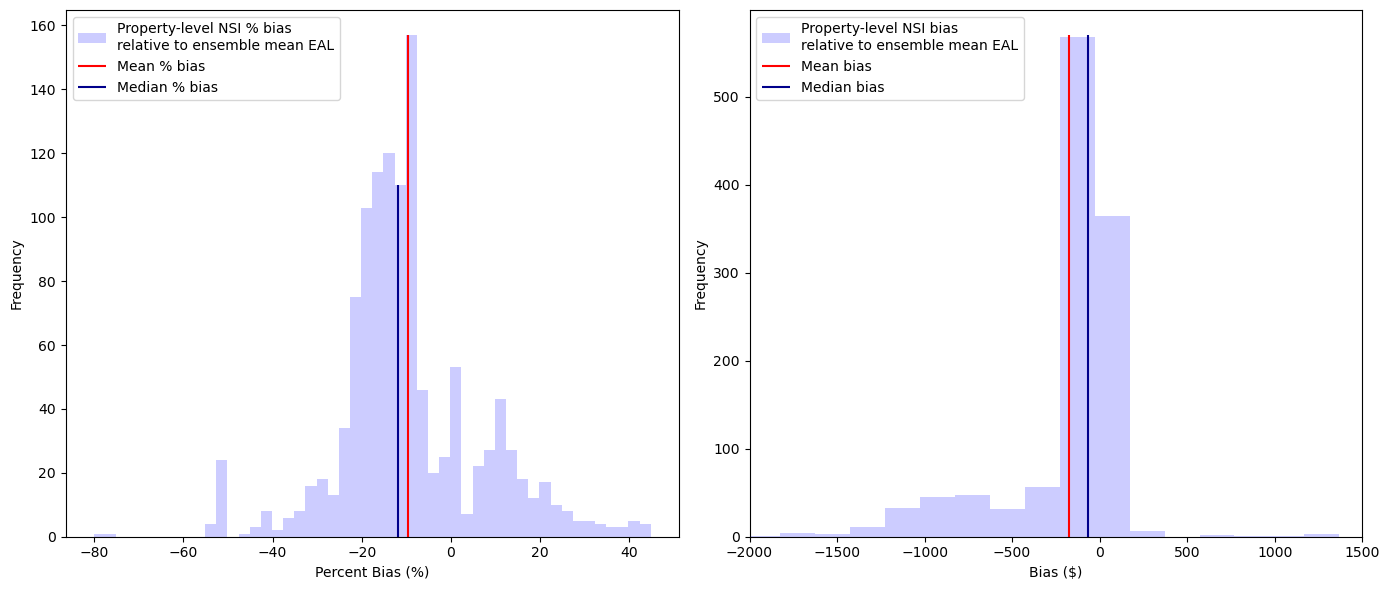

In [117]:
# Calculate the difference between mean EAL and default EAL
# Plot the distribution of these differences (the bias)
ens_means = ens_df.groupby(['fd_id'])['eal'].mean().reset_index()
mean_def_diff = pd.merge(ens_means,
                         def_df[['fd_id', 'eal']],
                         on='fd_id',
                         suffixes=['_ens', '_def'])
mean_def_diff['pct_bias'] = 100*(mean_def_diff['eal_def'] - mean_def_diff['eal_ens'])/mean_def_diff['eal_ens']
mean_def_diff['bias'] = (mean_def_diff['eal_def'] - mean_def_diff['eal_ens'])
fig, ax = plt.subplots(figsize=(14, 6), ncols=2)
mean_def_diff['pct_bias'].plot(kind='hist', ax=ax[0], color='blue', bins=50, alpha=.2,
                           label='Property-level NSI % bias\nrelative to ensemble mean EAL')
ax[0].vlines(mean_def_diff['pct_bias'].mean(), 0, 157, color='red', alpha=1, label='Mean % bias')
ax[0].vlines(mean_def_diff['pct_bias'].median(), 0, 110, color='darkblue', alpha=1, label='Median % bias')
ax[0].set_xlabel('Percent Bias (%)')
ax[0].legend(loc='upper left')

mean_def_diff['bias'].plot(kind='hist', ax=ax[1], color='blue', bins=50, alpha=.2,
                           label='Property-level NSI bias\nrelative to ensemble mean EAL')
ax[1].vlines(mean_def_diff['bias'].mean(), 0, 570, color='red', alpha=1, label='Mean bias')
ax[1].vlines(mean_def_diff['bias'].median(), 0, 570, color='darkblue', alpha=1, label='Median bias')
ax[1].set_xlabel('Bias ($)')
ax[1].legend(loc='upper left')
ax[1].set_xlim([-2000, 1500])
fig.tight_layout()